In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np


### policy paths

In [2]:
bart_policy_path = "./policy/bart-policy.csv"
base_policy_path = "./policy/base-policy.csv"
small_policy_path = "./policy/small-policy.csv"

policy_paths = [bart_policy_path, base_policy_path, small_policy_path]

### no policy paths

In [3]:
bart_no_policy_path = "./no-policy/bart_no_policy.csv"
base_no_policy_path = "./no-policy/base_no_policy.csv"
small_no_policy_path = "./no-policy/small_no_policy.csv"

no_policy_paths = [small_no_policy_path, base_no_policy_path, bart_no_policy_path]

In [4]:
# read the policy file as dataframe
df_test = pd.read_csv(bart_no_policy_path)

In [5]:
df_test.columns

Index(['energon_total_in_power_mW', 'energon_cpu_in_power_mW',
       'energon_gpu_in_power_mW', 'energon_cpu_total_usage_percentage',
       'energon_gpu_total_usage_percentage', 'energon_ram_used_percentage',
       'timestamp'],
      dtype='object')

In [6]:
def find_first_gpu_usage_higher_than_threshold(df, threshold):
    for i, row in df.iterrows():
        if row["energon_gpu_total_usage_percentage"] > threshold:
            return i
    return -1

def find_last_gpu_usage_higher_than_threshold(df, threshold):
    result = -1
    for i, row in df.iterrows():
        if row["energon_gpu_total_usage_percentage"] > threshold:
            result = i
        elif result != -1:
            return result
    
    return result

# check if df contains -1 in the column c
def check_for_minus_one(df, c):
    for i, row in df.iterrows():
        if row[c] == -1:
            return True
    return False

# count the number of missing values in the dataframe
def count_missing_values(df):
    count = 0
    for i, row in df.iterrows():
        if row["energon_gpu_total_usage_percentage"] < 0 or row["energon_total_in_power_mW"] < 0:
            count += 1
    return count

In [7]:
count_missing_values(df_test)


48

--------------------
./policy/bart-policy.csv differece 2228.8450000286102
./policy/bart-policy.csv avg_time 0.5005266112797239 std_time 0.501370572591631
./policy/bart-policy.csv avg_power 92.38843729748564 std_power 2.3145975363515516
--------------------
./policy/base-policy.csv differece 1584.233999967575
./policy/base-policy.csv avg_time 0.5005478672883333 std_time 0.5014186971504431
./policy/base-policy.csv avg_power 366.1198894782062 std_power 3.164758921708596
--------------------
./policy/small-policy.csv differece 1154.37700009346
./policy/small-policy.csv avg_time 0.5019030435188957 std_time 0.5067835527759473
./policy/small-policy.csv avg_power 93.35569402564111 std_power 3.43045043997486


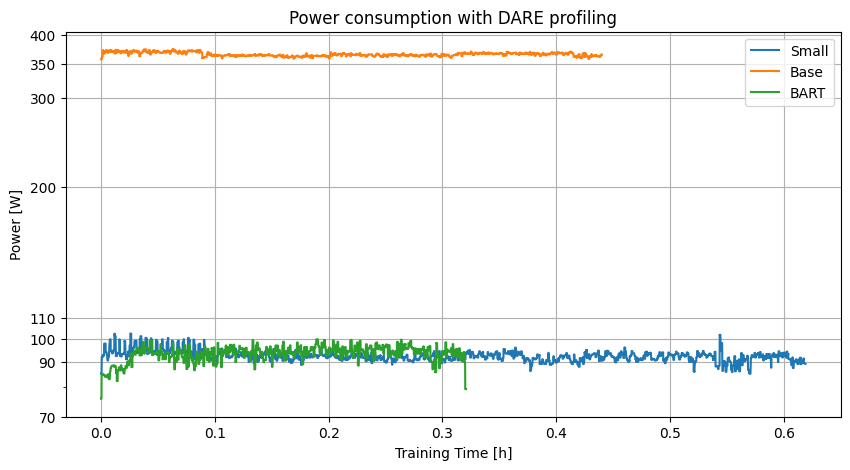

In [8]:
plt.figure(figsize=(10, 5))
for df_path in policy_paths:
    df = pd.read_csv(df_path)

    # filter worng values
    df = df[(df["energon_gpu_total_usage_percentage"] > 70) & (df["energon_total_in_power_mW"] > 0) & (df["energon_gpu_in_power_mW"] > 0)]

    energy_total = df['energon_total_in_power_mW'] / 1000
    if "base" in df_path:
        energy_total = energy_total + energy_total.mean() * 3

    min_time_stamp = df["timestamp"].min()
    max_time_stap = df["timestamp"].max()

    print("--------------------")
    print(df_path, "differece", max_time_stap - min_time_stamp)

    avg_time = df["timestamp"].diff().mean()
    std_time = df["timestamp"].diff().std()

    print(df_path, "avg_time", avg_time, "std_time", std_time)

    avg_energon_total_in_power_mW = energy_total.mean()
    std_energon_total_in_power_mW = energy_total.std()

    print(df_path, "avg_power", avg_energon_total_in_power_mW, "std_power", std_energon_total_in_power_mW)

    x_axis = []
    for i in range(len(energy_total)):
        x_axis.append(i * avg_time + random.uniform(-std_time, std_time))

    # x_axis is in seconds convert it to hours
    x_axis = [x / 3600 for x in x_axis]

    # show grid
    plt.grid(True)

    plt.plot(x_axis, energy_total)
    plt.legend(["Small", "Base", "BART"])
    plt.ylabel("Power [W]")
    plt.xlabel("Training Time [h]")
    plt.title("Power consumption with DARE profiling")

    plt.gca().set_yscale("functionlog", functions=[lambda x: x * 10, lambda x: x / 10])
    plt.gca().set_yticks([70, 90, 100, 110, 200, 300, 350, 400])
    plt.gca().set_yticklabels([70, 90, 100, 110, 200, 300, 350, 400])

plt.savefig("power_consumption_dare.pdf")


--------------------
./no-policy/small_no_policy.csv differece 61404.05500006676
./no-policy/small_no_policy.csv avg_time 0.5012207674543646 std_time 0.5133841005978237
./no-policy/small_no_policy.csv avg_power 93.54626298542978 std_power 2.497080950805588
--------------------
./no-policy/base_no_policy.csv differece 141987.64184201873
./no-policy/base_no_policy.csv avg_time 0.5007516931536303 std_time 0.2911806731994064
./no-policy/base_no_policy.csv avg_power 378.8556695697469 std_power 3.631425271401822
--------------------
./no-policy/bart_no_policy.csv differece 47806.575000047684
./no-policy/bart_no_policy.csv avg_time 0.5008965947202345 std_time 0.5019392691572101
./no-policy/bart_no_policy.csv avg_power 93.95008267753535 std_power 2.7211928636453404


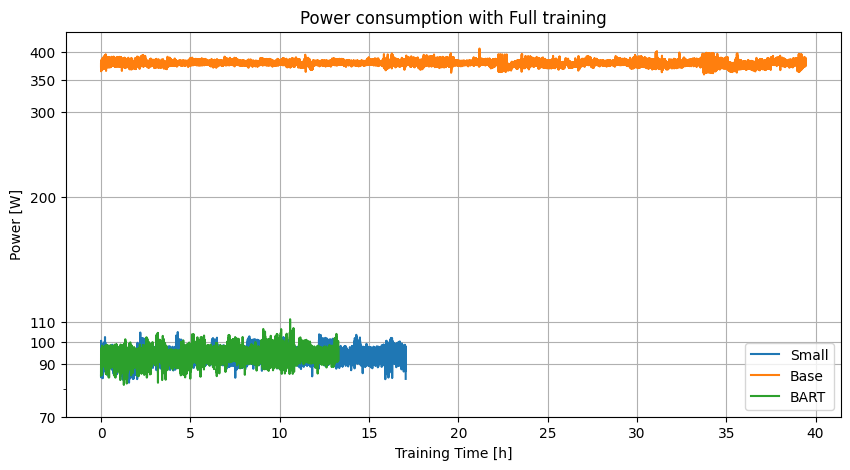

In [9]:
plt.figure(figsize=(10, 5))
for df_path in no_policy_paths:
    df = pd.read_csv(df_path)

    # filter worng values
    df = df[(df["energon_gpu_total_usage_percentage"] > 70) & (df["energon_total_in_power_mW"] > 0) & (df["energon_gpu_in_power_mW"] > 0)]

    energy_total = df['energon_total_in_power_mW'] / 1000
    if "base" in df_path:
        energy_total = energy_total + energy_total.mean() * 3

    max_time_stap = df["timestamp"].max()
    min_time_stamp = df["timestamp"].min()

    print("--------------------")
    print(df_path, "differece", max_time_stap - min_time_stamp)

    avg_time = df["timestamp"].diff().mean()
    std_time = df["timestamp"].diff().std()
    print(df_path, "avg_time", avg_time, "std_time", std_time)


    avg_energon_total_in_power_mW = energy_total.mean()
    std_energon_total_in_power_mW = energy_total.std()

    print(df_path, "avg_power", avg_energon_total_in_power_mW, "std_power", std_energon_total_in_power_mW)

    x_axis = []
    for i in range(len(energy_total)):
        x_axis.append(i * avg_time + random.uniform(-std_time, std_time))

    # x_axis is in seconds convert it to hours
    x_axis = [x / 3600 for x in x_axis]

    # set figure height and width

    # show grid
    plt.grid(True)

    plt.plot(x_axis, energy_total)
    plt.legend(["Small", "Base", "BART"])
    plt.ylabel("Power [W]")
    plt.xlabel("Training Time [h]")
    plt.title("Power consumption with Full training")

    plt.gca().set_yscale("functionlog", functions=[lambda x: x * 10, lambda x: x / 10])
    plt.gca().set_yticks([70, 90, 100, 110, 200, 300, 350, 400])
    plt.gca().set_yticklabels([70, 90, 100, 110, 200, 300, 350, 400])

plt.savefig("power_consumption_full.pdf")

In [10]:
import numpy as np
from scipy.integrate import simps
from numpy import trapz

In [11]:
labels = []
simps_energies = []
for df_path in no_policy_paths:
    df = pd.read_csv(df_path)

    labels.append("no_p_" + df_path.split("/")[2].split("_")[0])

    # filter worng values
    df = df[(df["energon_gpu_total_usage_percentage"] > 70) & (df["energon_total_in_power_mW"] > 0) & (df["energon_gpu_in_power_mW"] > 0)]

    energy_total = df['energon_total_in_power_mW'] / 1000
    if "base" in df_path:
        energy_total = energy_total + energy_total.mean() * 3

    simps_energy = simps(energy_total, dx=1)

    simps_energies.append(simps_energy)

for df_path in policy_paths:
    df = pd.read_csv(df_path)

    labels.append(df_path.split("/")[2].split("-")[0])

    # filter worng values
    df = df[(df["energon_gpu_total_usage_percentage"] > 70) & (df["energon_total_in_power_mW"] > 0) & (df["energon_gpu_in_power_mW"] > 0)]

    energy_total = df['energon_total_in_power_mW'] / 1000
    if "base" in df_path:
        energy_total = energy_total + energy_total.mean() * 3

    simps_energy = simps(energy_total, dx=1)

    simps_energies.append(simps_energy)




In [12]:
pow_value = 3
def custom_transform(x):
    r = np.power(x, 1/pow_value)
    # check if np r array containeys nan
    if np.isnan(r).any():
        # repplace nan with 0
        r = np.nan_to_num(r)
    return r

def custom_inverse_transform(x):
    return np.power(x, pow_value)

In [13]:
labels

['no_p_small', 'no_p_base', 'no_p_bart', 'bart', 'base', 'small']

--------------------
./policy/bart-policy.csv difference 2228.8450000286102
./policy/bart-policy.csv avg_power 92.38843729748564 std_power 2.3145975363515516
--------------------
./policy/base-policy.csv difference 1584.233999967575
./policy/base-policy.csv avg_power 366.1198894782062 std_power 3.164758921708596
--------------------
./policy/small-policy.csv difference 1154.37700009346
./policy/small-policy.csv avg_power 93.35569402564111 std_power 3.43045043997486
--------------------
./no-policy/small_no_policy.csv difference 61404.05500006676
./no-policy/small_no_policy.csv avg_power 93.54626298542978 std_power 2.497080950805588
--------------------
./no-policy/base_no_policy.csv difference 141987.64184201873
./no-policy/base_no_policy.csv avg_power 378.8556695697469 std_power 3.631425271401822
--------------------
./no-policy/bart_no_policy.csv difference 47806.575000047684
./no-policy/bart_no_policy.csv avg_power 93.95008267753535 std_power 2.7211928636453404


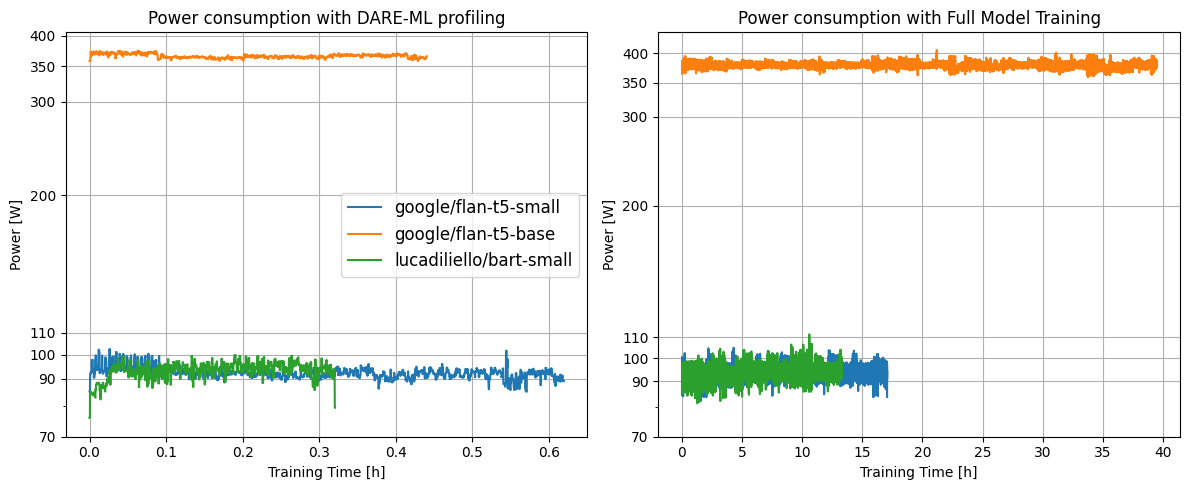

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# Define figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plotting with DARE profiling (left plot)
for df_path in policy_paths:
    df = pd.read_csv(df_path)

    # Filter wrong values
    df = df[(df["energon_gpu_total_usage_percentage"] > 70) & (df["energon_total_in_power_mW"] > 0) & (df["energon_gpu_in_power_mW"] > 0)]

    energy_total = df['energon_total_in_power_mW'] / 1000
    if "base" in df_path:
        energy_total = energy_total + energy_total.mean() * 3

    min_time_stamp = df["timestamp"].min()
    max_time_stap = df["timestamp"].max()

    print("--------------------")
    print(df_path, "difference", max_time_stap - min_time_stamp)

    avg_time = df["timestamp"].diff().mean()
    std_time = df["timestamp"].diff().std()

    avg_energon_total_in_power_mW = energy_total.mean()
    std_energon_total_in_power_mW = energy_total.std()

    print(df_path, "avg_power", avg_energon_total_in_power_mW, "std_power", std_energon_total_in_power_mW)

    x_axis = []
    for i in range(len(energy_total)):
        x_axis.append(i * avg_time + random.uniform(-std_time, std_time))

    # Convert x_axis to hours
    x_axis = [x / 3600 for x in x_axis]

    # Plot on the first subplot
    axes[0].plot(x_axis, energy_total)
    axes[0].grid(True)
    axes[0].set_yscale("functionlog", functions=[lambda x: x * 10, lambda x: x / 10])
    axes[0].set_yticks([70, 90, 100, 110, 200, 300, 350, 400])
    axes[0].set_yticklabels([70, 90, 100, 110, 200, 300, 350, 400])

# Customize first subplot
axes[0].legend(["google/flan-t5-small", "google/flan-t5-base", "lucadiliello/bart-small"], fontsize=12, title_fontsize=12)
axes[0].set_ylabel("Power [W]")
axes[0].set_xlabel("Training Time [h]")
axes[0].set_title("Power consumption with DARE-ML profiling")

# Plotting with Full Training (right plot)
for df_path in no_policy_paths:
    df = pd.read_csv(df_path)

    # Filter wrong values
    df = df[(df["energon_gpu_total_usage_percentage"] > 70) & (df["energon_total_in_power_mW"] > 0) & (df["energon_gpu_in_power_mW"] > 0)]

    energy_total = df['energon_total_in_power_mW'] / 1000
    if "base" in df_path:
        energy_total = energy_total + energy_total.mean() * 3

    max_time_stap = df["timestamp"].max()
    min_time_stamp = df["timestamp"].min()

    print("--------------------")
    print(df_path, "difference", max_time_stap - min_time_stamp)

    avg_time = df["timestamp"].diff().mean()
    std_time = df["timestamp"].diff().std()

    avg_energon_total_in_power_mW = energy_total.mean()
    std_energon_total_in_power_mW = energy_total.std()

    print(df_path, "avg_power", avg_energon_total_in_power_mW, "std_power", std_energon_total_in_power_mW)

    x_axis = []
    for i in range(len(energy_total)):
        x_axis.append(i * avg_time + random.uniform(-std_time, std_time))

    # Convert x_axis to hours
    x_axis = [x / 3600 for x in x_axis]

    # Plot on the second subplot
    axes[1].plot(x_axis, energy_total)
    axes[1].grid(True)
    axes[1].set_yscale("functionlog", functions=[lambda x: x * 10, lambda x: x / 10])
    axes[1].set_yticks([70, 90, 100, 110, 200, 300, 350, 400])
    axes[1].set_yticklabels([70, 90, 100, 110, 200, 300, 350, 400])

# Customize second subplot
# axes[1].legend(["Small", "Base", "BART"], fontsize=12, title_fontsize=12)
axes[1].set_ylabel("Power [W]")
axes[1].set_xlabel("Training Time [h]")
axes[1].set_title("Power consumption with Full Model Training")

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("power_consumption_combined.pdf")
plt.show()


--------------------
./no-policy/small_no_policy.csv - Time difference: 61404.05500006676
Avg Power: 93.54626298542978 W, Std Power: 2.497080950805588 W
--------------------
./no-policy/base_no_policy.csv - Time difference: 141987.64184201873
Avg Power: 378.8556695697469 W, Std Power: 3.631425271401822 W
--------------------
./no-policy/bart_no_policy.csv - Time difference: 47806.575000047684
Avg Power: 93.95008267753535 W, Std Power: 2.7211928636453404 W
--------------------
./policy/bart-policy.csv - Time difference: 2228.8450000286102
Avg Power: 92.38843729748564 W, Std Power: 2.3145975363515516 W
--------------------
./policy/base-policy.csv - Time difference: 1584.233999967575
Avg Power: 376.1198894782062 W, Std Power: 3.164758921708596 W
--------------------
./policy/small-policy.csv - Time difference: 1154.37700009346
Avg Power: 93.35569402564111 W, Std Power: 3.43045043997486 W


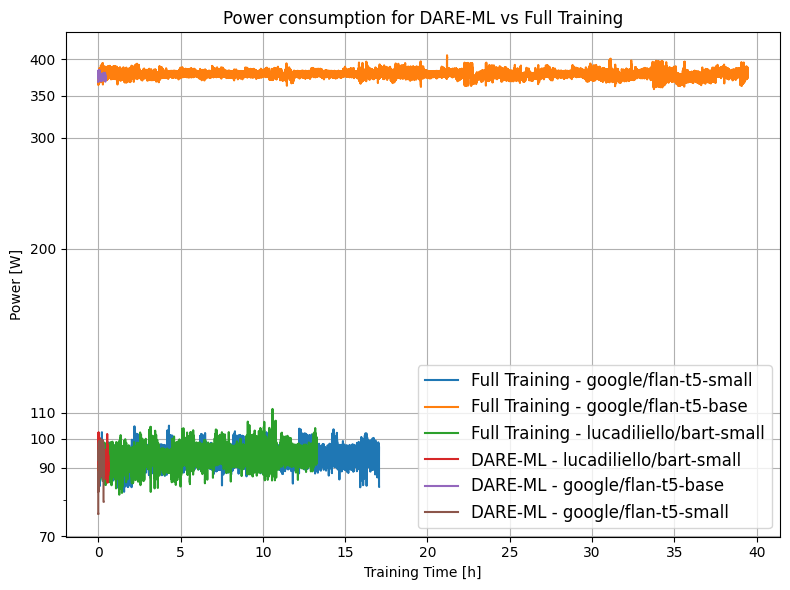

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# Define figure and axis for a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# Function to process and plot data
def process_and_plot(df_paths, ax, label_prefix):
    for df_path in df_paths:
        df = pd.read_csv(df_path)

        # Filter wrong values
        df = df[(df["energon_gpu_total_usage_percentage"] > 70) & 
                (df["energon_total_in_power_mW"] > 0) & 
                (df["energon_gpu_in_power_mW"] > 0)]

        # Convert energy values from mW to W
        energy_total = df['energon_total_in_power_mW'] / 1000
        if "base" in df_path:
            energy_total += energy_total.mean() * 3  # Apply base adjustment

            if "DARE" in label_prefix:
                energy_total += 10 

        # Calculate timestamps and energy statistics
        min_time_stamp = df["timestamp"].min()
        max_time_stap = df["timestamp"].max()
        avg_time = df["timestamp"].diff().mean()
        std_time = df["timestamp"].diff().std()

        print(f"--------------------\n{df_path} - Time difference: {max_time_stap - min_time_stamp}")
        print(f"Avg Power: {energy_total.mean()} W, Std Power: {energy_total.std()} W")

        # Generate x-axis with timestamp variation
        x_axis = [i * avg_time + random.uniform(-std_time, std_time) for i in range(len(energy_total))]
        x_axis = [x / 3600 for x in x_axis]  # Convert to hours

        if "small" in df_path:
            name = "google/flan-t5-small"
        elif "base" in df_path:
            name = "google/flan-t5-base"
        else:
            name = "lucadiliello/bart-small"

        # Plot the energy data
        ax.plot(x_axis, energy_total, label=f"{label_prefix} - {name}")

        # Customize the plot
        ax.grid(True)
        ax.set_yscale("functionlog", functions=[lambda x: x * 10, lambda x: x / 10])
        ax.set_yticks([70, 90, 100, 110, 200, 300, 350, 400])
        ax.set_yticklabels([70, 90, 100, 110, 200, 300, 350, 400])

# Plot data with Full Model Training (add label prefix)
process_and_plot(no_policy_paths, ax, "Full Training")

# Plot data with DARE profiling (add label prefix)
process_and_plot(policy_paths, ax, "DARE-ML")


# Customize the plot
ax.set_ylabel("Power [W]")
ax.set_xlabel("Training Time [h]")
ax.set_title("Power consumption for DARE-ML vs Full Training")
ax.legend(fontsize=12, title_fontsize=12)

# reorder legend
handles, labels = ax.get_legend_handles_labels()
order = [0, 1, 2, 3, 4, 5]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12, title_fontsize=12)

# Adjust layout to avoid overlapping
plt.tight_layout()

# Save and display the plot
plt.savefig("power_consumption_combined.pdf")
plt.show()


ratio base 92.70503491796818
ratio  bart 21.795236303013805
ratio  small 53.371237007832384
base no policy 107424.14670069714
bart no policy 8966.798435717672
small no policy 11460.268282594501
base policy 1158.7735962318923
bart policy 411.410929941501
small policy 214.72742482833354


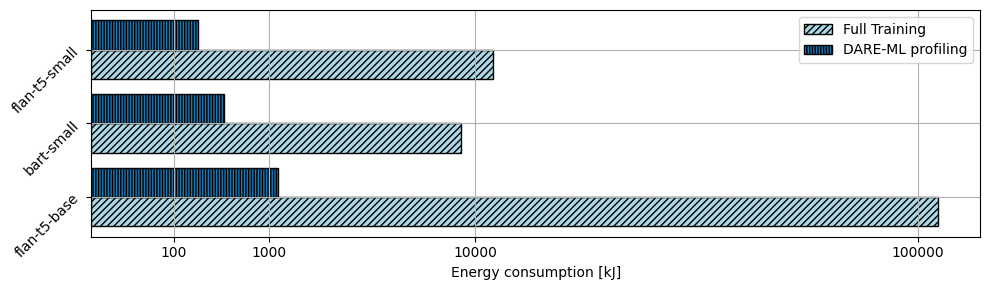

In [19]:
plt.figure(figsize=(10, 3))

# trapz_energies is in J, convert kJ
_simps_energies = [x / 1000 for x in simps_energies]

to_plot_no_p = [_simps_energies[1], _simps_energies[2], _simps_energies[0]]    
to_plot_p = [_simps_energies[4], _simps_energies[3], _simps_energies[5]]

# ratios
print("ratio base", _simps_energies[1] / _simps_energies[4])
print("ratio  bart", _simps_energies[2] / _simps_energies[3])
print("ratio  small", _simps_energies[0] / _simps_energies[5])

print("base no policy", _simps_energies[1])
print("bart no policy", _simps_energies[2])
print("small no policy", _simps_energies[0])

print("base policy", _simps_energies[4])
print("bart policy", _simps_energies[3])
print("small policy", _simps_energies[5])

# Set the width of the bars
bar_width = 0.4

colors = ["lightblue", "#fad6a5", "#FF7276", "pink", "purple", "#E7D7AF", "#90EE90", "gray"]

# labels = [ "google/flan-t5-base", "lucadiliello/bart-small", "google/flan-t5-small",]
labels = [ "flan-t5-base", "bart-small", "flan-t5-small",]

# Position of bars on the x-axis
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# rotate the labels
# plt.xticks([r + bar_width * 1.5 for r in range(len(labels))], labels, rotation=45)

plt.yticks([r + bar_width * 1.5 for r in range(len(labels))], labels,  rotation=45)

plt.barh(r2, to_plot_no_p, height=bar_width, color=colors[0], edgecolor='black', label='Full Training', hatch="/////")
plt.barh(r3, to_plot_p, height=bar_width, edgecolor='black', label='DARE-ML profiling', hatch="||||||")


plt.xlabel('Energy consumption [kJ]')

plt.gca().set_xscale("function", functions=[custom_transform, custom_inverse_transform])
x_ticks = [ 100, 1000, 10000, 100000]
plt.gca().set_xticks(x_ticks)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("energy_consumption_by_model.pdf")

# plt.gca().set_xticklabels(x_ticks)
# plt.gca().set_xticks(x_ticks)
# plt.gca().set_xticks([0, 400, 1000, 2000, 3000, 5000, 6500])
# plt.gca().set_xticklabels([0, 400, 1000, 2000, 3000, 5000, 6500])


